# XGBOOST MODEL IMPLEMENTATION:

We now want to predict whether cells are in Hypoxia or Normoxia based on their gene expression, this is a binary classification problem (Hypoxia yes/no).
Since the number of features is enormous, we first employ some methods to reduce dimensionality and then run our xgboost model on it.
Xgboost is a prominent ML model know for its speed and great performance.

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier

In [68]:
mcf7_fil = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ",engine='python',index_col=0)
mcf7_fil_T = mcf7_fil.T
df_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t",engine='python',index_col=0)

In [69]:
#Remove extra quotes from the filenames
def extract_cell_name(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name(file_name):
    return extract_cell_name(file_name)

def convert_indexes_to_cell_names(df):
    df.index = [get_cell_name(x) for x in df.index]
    return df

def get_cell_hypo_or_norm(cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm(x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm(x)=="Norm")]
    return df_hypo, df_norm

def process_df(df):
    df = convert_indexes_to_cell_names(df)
    df_hypo, df_norm = seperate_hypo_and_norm(df)
    return df, df_hypo, df_norm

mcf7_fil_T, mcf7_fil_T_hypo, mcf7_fil_T_norm = process_df(mcf7_fil_T.copy())
mcf7_fil = mcf7_fil_T.T
mcf7_fil_hypo = mcf7_fil_T_hypo.T
mf7_fil_norm = mcf7_fil_T_norm.T

### PCA

In [70]:
# Run PCA on mcf7_fil, it should explain 95% of the variance, then transform it back to pandas dataframe
from sklearn.decomposition import PCA
pca1 = PCA(n_components=0.9)
pca2 = PCA(n_components=0.9)

# scale mcf7_fil_T
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(mcf7_fil_T)

# PCA 1
pca1.fit(mcf7_fil_T)
mcf7_fil_T_pca = pca1.transform(mcf7_fil_T)
df = pd.DataFrame(mcf7_fil_T_pca, index=mcf7_fil_T.index)
#print(df.shape)
print(f'Explained variance for non-scaled data: {pca1.explained_variance_ratio_}')

# PCA 2
pca2.fit(data_scaled)
mcf7_fil_T_pca_scaled = pca2.transform(data_scaled)
# df = pd.DataFrame(mcf7_fil_T_pca, index=mcf7_fil_T.index)
# print(df.shape)
print(f'Explained variance for scaled data: {pca2.explained_variance_ratio_}')


Explained variance for non-scaled data: [0.6344835  0.09107496 0.06270155 0.04033215 0.03156572 0.01538185
 0.01138705 0.01009336 0.00898676]
Explained variance for scaled data: [0.07810178 0.027794   0.02571145 0.0192107  0.0178536  0.01607177
 0.0154759  0.01362122 0.01258472 0.01185127 0.01147435 0.01095676
 0.01010113 0.00989389 0.00956791 0.00900762 0.00884985 0.00862421
 0.00837575 0.00806777 0.00790965 0.00779767 0.00748881 0.00742935
 0.00724611 0.00711804 0.00701356 0.00687439 0.00673614 0.00661228
 0.00650138 0.00643796 0.00629391 0.00627591 0.00607082 0.00598068
 0.00586654 0.00574379 0.00572844 0.00564423 0.0055799  0.00545344
 0.00537146 0.00529837 0.00520262 0.00515814 0.00509715 0.00498684
 0.00496078 0.00485647 0.00479548 0.00475562 0.00472304 0.00467306
 0.00462158 0.00460554 0.00454328 0.00450755 0.00448258 0.00438596
 0.00435241 0.00432275 0.00429514 0.00423007 0.0041976  0.00412905
 0.00409119 0.00405352 0.00402898 0.00400458 0.00394898 0.00393876
 0.00390736 0.0038

In [86]:
mcf7_fil_T_hypo['target'] = 1
mcf7_fil_T_norm['target'] = 0
df['target'] = pd.concat([mcf7_fil_T_hypo['target'], (mcf7_fil_T_norm['target'])])
df

C:\Users\Asus\AppData\Local\Temp\ipykernel_22664\761231659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcf7_fil_T_hypo['target'] = 1
C:\Users\Asus\AppData\Local\Temp\ipykernel_22664\761231659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcf7_fil_T_norm['target'] = 0


,0,1,2,3,4,5,6,7,8,target
S57,-26874.672396,766.013957,-880.248212,281.301680,-780.044905,1693.459920,-4709.919726,2239.795667,1187.929883,0
S58,-26354.743000,5039.849020,-5372.826809,1857.001359,-1985.825161,1076.742069,-211.672685,2729.894074,-1552.417593,0
S59,-29351.253485,2414.726753,-3076.254097,658.589292,1286.583460,2644.762522,-580.985698,-1898.003000,-314.493781,0
S60,-24813.833293,-75.979072,-3934.877133,-27.692654,1912.368921,1730.324435,-667.352642,-666.443001,255.891198,0
S79,4454.732179,-1836.273354,-1595.912696,-2093.178655,-1011.474815,-6308.900910,469.104920,4400.242859,152.911742,1
...,...,...,...,...,...,...,...,...,...,...
S359,-18394.340467,-5274.416642,649.525614,-132.308368,2780.636273,697.693245,-2908.989688,974.887736,1323.692226,0
S360,-10023.164045,-14507.616731,-1941.969647,-2165.272571,184.614395,1250.971011,206.821563,-598.814233,464.255322,0
S379,603.697715,11492.308191,43230.690452,-12557.877258,-3888.219815,-2331.694403,-2859.892658,-3219.259720,1321.342579,1
S380,17016.931253,8398.335833,4439.884803,-8135.045349,-3468.089084,-8768.259345,-2749.385536,-5395.554787,656.218490,1


In [87]:
# Hyperparamets to tune

space = dict()
space['subsample'] = [0.25, 0.5, 0.75, 1.0] # row sampling
space['colsample_bytree'] = [0.25, 0.5, 0.75, 1.0] # column sampling
space['colsample_bylevel'] = [0.25, 0.5, 0.75, 1.0] # column sampling at each split

In [3]:
def tune_xgboost(X, y, space, n_estimators=100, balance=False):
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scoring = 'roc_auc'

    # find total negative and positive samples 
    total = len(y)
    total_positive = np.sum(y==1)
    total_negative = total - total_positive

    # set the scale pos weight
    scale_pos_weight = total_negative / total_positive if balance else 1

    # print total positive % and total negative %, and scale pos weight (all rounded)
    print(f'Total positive : {round(100*(total_positive/total), 3)}%')
    print(f'Total negative : {round(100*(total_negative/total), 3)}%')
    print(f'Scale pos weight: {round(scale_pos_weight, 3)}')

    # define the model
    model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=n_estimators, device='cuda', n_jobs=-1)
    # define search
    search = GridSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv)
    # execute search
    result = search.fit(X, y)
    
    # plot results
    results_df = pd.DataFrame(result.cv_results_)
    for key, values in space.items():
        
        # group the results by the hyperparameter
        param_means = []
        param_stds = []
        for value in values:
            mask = results_df['param_' + key] == value
            param_means.append(np.mean(results_df[mask]['mean_test_score']))
            param_stds.append(np.std(results_df[mask]['mean_test_score']))

        # create plot with two subplots side by side
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(key)
        ax[0].plot(values, param_means)
        ax[0].set_title('Mean test scores')
        ax[0].set_xlabel(key)
        ax[0].set_ylabel('mean scores')
        padding = 0.1
        ax[0].set_ylim(max(0, min(param_means) - padding), min(1, max(param_means) + padding))

        ax[1].plot(values, param_stds)
        ax[1].set_title('Mean score std')
        ax[1].set_xlabel(key)
        ax[1].set_ylabel('score std')
        padding = 0.05
        ax[1].set_ylim(max(0, min(param_stds) - padding), min(1, max(param_stds) + padding))

        plt.show()

    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters:')
    for k, v in result.best_params_.items():
        print('%s: %s' % (k, v))

    # best model
    best_model = result.best_estimator_

    return result.best_params_, best_model

Total positive : 49.333%
Total negative : 50.667%
Scale pos weight: 1


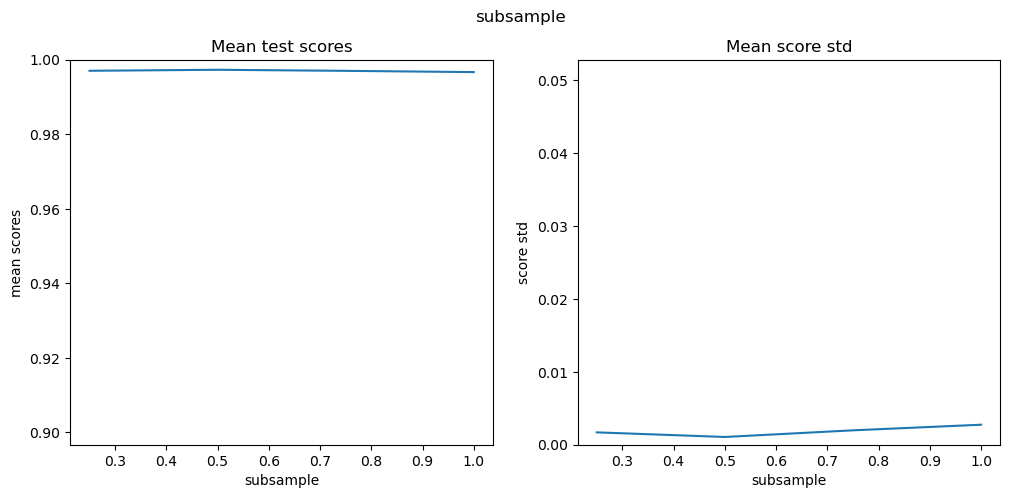

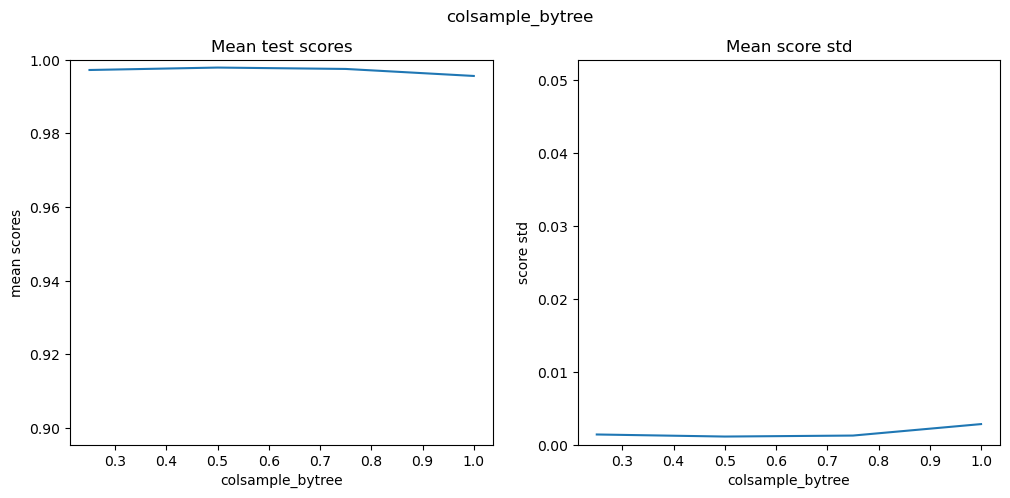

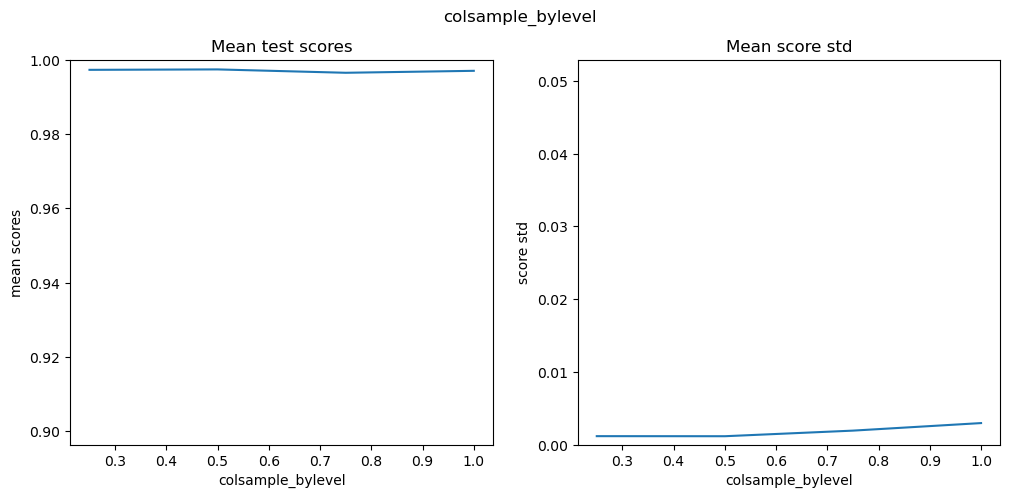

Best Score: 0.9994729907773385
Best Hyperparameters:
colsample_bylevel: 1.0
colsample_bytree: 0.25
subsample: 0.25


In [91]:
# reserve 10% of the data for validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.1, random_state=42)

best_parameters, best_model = tune_xgboost(X_train, y_train, space, n_estimators=50, balance=False)

In [92]:
# evaluate the model
from sklearn.metrics import roc_auc_score
y_pred = best_model.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 1.0


c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:28:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [93]:
y_pred

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0])